## Early-Exercise Region for the American Put

### Import Libraries

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
from numpy.polynomial import laguerre

### Input Parameters

In [2]:
# Option parameters
K = 100              # Strike price
S0 = 80              # Initial Stock Price
T = 1                # Time to Expiry in years
r = 0.05             # risk free rate
delta = 0.0          # Dividend Yield
sigma = 0.2          # Volatility
n = 365              # No. of days (time steps)
N = 100_000          # No. of Simulations

### Functions

#### Function 1: Implement Cox-Ross-Rubinstein Binomial Tree

In [3]:
def crr_binomial_tree(K, S0, T, r, delta, sigma, n):
    """
    Calculates the early exercise value for an American put option 
    using the Cox-Ross-Rubinstein (CRR)  binomial tree model. 

    Returns:
    EE: float, early exercise value of the American put option
    """
    # Calculation of CRR model parameters
    dt = T / n                                    
    df = np.exp(-r*dt)                            
    u = np.exp(sigma*np.sqrt(dt))                 
    d = 1/u                                       
    p = (np.exp(dt * (r - delta)) - d) / (u - d)  
    q = 1 - p                                     

    # Initialization of necessary variables
    S = np.zeros((n+1, n+1))                      
    payoff = np.zeros((n+1, n+1))                 
    EV = np.zeros((n+1, n+1))                     
    EE = np.zeros(n)                              
    
    # Looping through time steps backwards from the last time step
    for i in range(n, -1, -1):
        for j in range(i+1):
            S[j,i] = S0 * u**(i-j) * d**j     
            payoff[j,i] = max(K - S[j,i], 0)          
            if i == n: EV[j,i] = payoff[j,i]  
            else: EV[j,i] = df * (p * EV[j,i+1] + q * EV[j+1, i+1]) 
                
        if i != n:
            # Check if early exercise is optimal at each node and update expected value accordingly
            ind = payoff[:,i]-1e-6 > EV[:,i]   
            EE[i] = np.max(S[ind,i])           
            EV[ind,i] = payoff[ind,i]          

    return EE

#### Function 2: Implement Least Square Monte Carlo method of Longstaff and Schwartz (2001)

In [4]:
def long_schwartz_american_put_LSMC(K, S0, T, r, delta, sigma, n, N):
    """
    This function calculates the early exercise boundaries for an American put option using the 
    Longstaff-Schwartz Monte Carlo algorithm. It returns a 2-dimensional array containing the 95th 
    and 100th percentile exercise boundaries at each time step.
    
    Longstaff-Schwartz in their 2001 paper introduced how in each backward taking only the nodes 
    where payoff is greater than zero for implementing LSMC is more efficient. This works better 
    for in the money options.

    """
    ## LSMC model parameters
    dt = T / n           
    df = np.exp(-r*dt)   
    d = 20               
    
    ## Simulate N paths of the price process
    S = np.zeros((n+1, N))           
    S[0,:] = S0                      
    for i in range(n):               
        z = np.random.normal(size=N) 
        S[i+1,:] = S[i,:] * np.exp((r-delta-0.5*sigma**2)*dt + sigma*m.sqrt(dt)*z)  
    
    ## Initialise arrays
    payoff = np.maximum(K - S, 0)    
    V = np.zeros_like(S)             
    V[-1, :] = payoff[-1, :]         
    EE_boundary = np.zeros((2, n))   
    
    start = time()                   
    ## Iterate over time steps backwards
    for t in range(n, 0, -1):        
        V[t-1,:] = V[t,:] * df       
        ind = payoff[t - 1,:] > 0    
        
        ## Create the polynomial basis matrix using Laguerre polynomials
        psi = np.zeros((np.sum(ind), d+1))
        for i in range(d+1):
            p = laguerre.Laguerre.basis(i).coef          
            psi[:,i] = laguerre.lagval(S[t-1, ind], p)   
        q_psi, r_psi = np.linalg.qr(psi)                 
        b = q_psi.T @ V[t, ind] * df  
        CV = q_psi @ b                
        EE_95 = np.quantile(S[t-1,ind][payoff[t-1,ind] > CV], 0.95+(0.05*(t/n)))  # calculate 95% exercise boundary
        EE_100 = np.quantile(S[t-1,ind][payoff[t-1,ind] > CV], 1)                 # calculate 100% exercise boundary
        EE_boundary[0,t-1] = EE_95
        EE_boundary[1,t-1] = EE_100     
        # Set maximum of continuation value (CV) or payoff as the value of option at each node for current time step
        V[t - 1, ind] = np.maximum(CV, payoff[t-1, ind]) 

    end = time()                                       
    print("Time taken for calculation: ", end - start) 

    # Return a 2d array containing the 95th and 100th percentile exercise boundaries at each time step
    return EE_boundary 

#### Function 3: Plot the all estimated EE boundaries

In [5]:
def plot_ee_boundaries_100(EE_crr, EE_LSMC, n):
    # Fit a 5th-order polynomial to the Binomial Tree EE values
    t = np.linspace(0, n, n)
    poly_coeffs = np.polyfit(t, EE_crr, 5)
    EE_crr_poly = np.polyval(poly_coeffs, t)
  
    fig, ax = plt.subplots(figsize=(16,10))
    
    # Plot the estimated EE boundary and the polynomial fit
    ax.plot(t, EE_crr, '-', label='Estimated EE boundary')
    ax.plot(t, EE_crr_poly, 'r-', label='5th-order polynomial fit')
    
    # Plot EE boundary as points
#     ax.plot(t, EE_LSMC[0,:], '*', color='black', label='95 percentile LSMC EE boundary')
    ax.plot(t, EE_LSMC[1,:], '*', color='green', label='100 percentile LSMC EE boundary')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock price')
    ax.set_title('Early Exercise Region for American Put Option')
    ax.legend()
    plt.show()

In [6]:
def plot_ee_boundaries_95(EE_crr, EE_LSMC, n):
    # Fit a 5th-order polynomial to the Binomial Tree EE values
    t = np.linspace(0, n, n)
    poly_coeffs = np.polyfit(t, EE_crr, 5)
    EE_crr_poly = np.polyval(poly_coeffs, t)
  
    fig, ax = plt.subplots(figsize=(16,10))
    
    # Plot the estimated EE boundary and the polynomial fit
    ax.plot(t, EE_crr, '-', label='Estimated EE boundary')
    ax.plot(t, EE_crr_poly, 'r-', label='5th-order polynomial fit')
    
    # Plot EE boundary as points
    ax.plot(t, EE_LSMC[0,:], '*', color='black', label='95 percentile LSMC EE boundary')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock price')
    ax.set_title('Early Exercise Region for American Put Option')
    ax.legend()
    plt.show()

### Estimate Early Exercise Region for American put using LSMC and Binomial Tree

In [7]:
EE_crr = crr_binomial_tree(K, S0, T, r, delta, sigma, n)
EE_LSMC = long_schwartz_american_put_LSMC(K, S0, T, r, delta, sigma, n, N)

Time taken for calculation:  72.66027426719666


### Plot the estimated EE Boundaries:
- EE Boundary estimated through CRR Binomial Tree
- EE Boundary estimated through CRR Binomial Tree fitted to fifth order polynomial
- EE Boundary estimated through LSMC Model for 95th and 100th percentile using the equation below

$$\mathrm{s^\ast\left(t_i\right)=\text{quantile}_{\left(95+5\ast\left(\frac{i}{n}\right)\right)}\left[\left(S_i^l\right)_{l\le N}\middle | \max\left(K-S_i^l,0\right)=V\left(i,S_i^l\right)\right]}$$

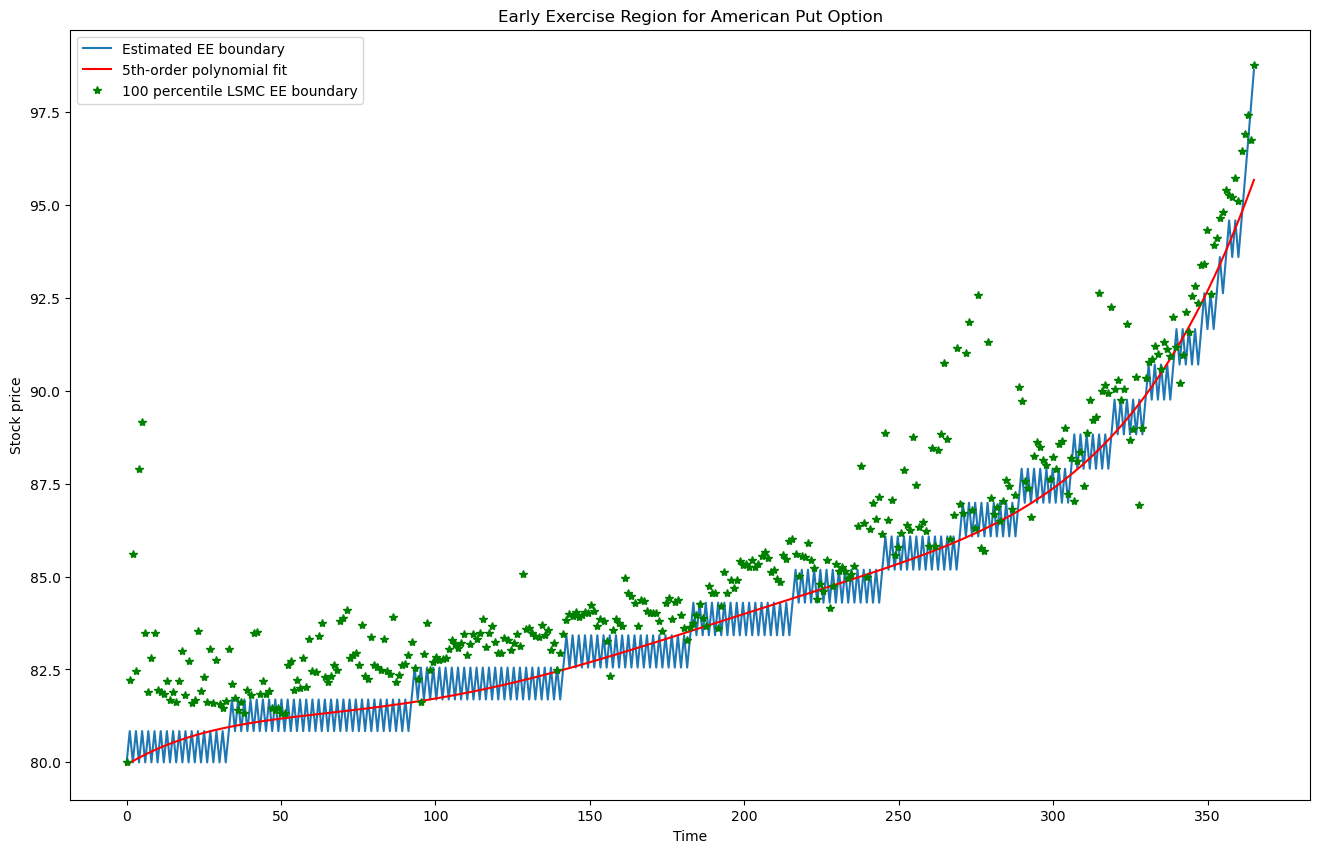

In [8]:
plot_ee_boundaries_100(EE_crr, EE_LSMC, n)

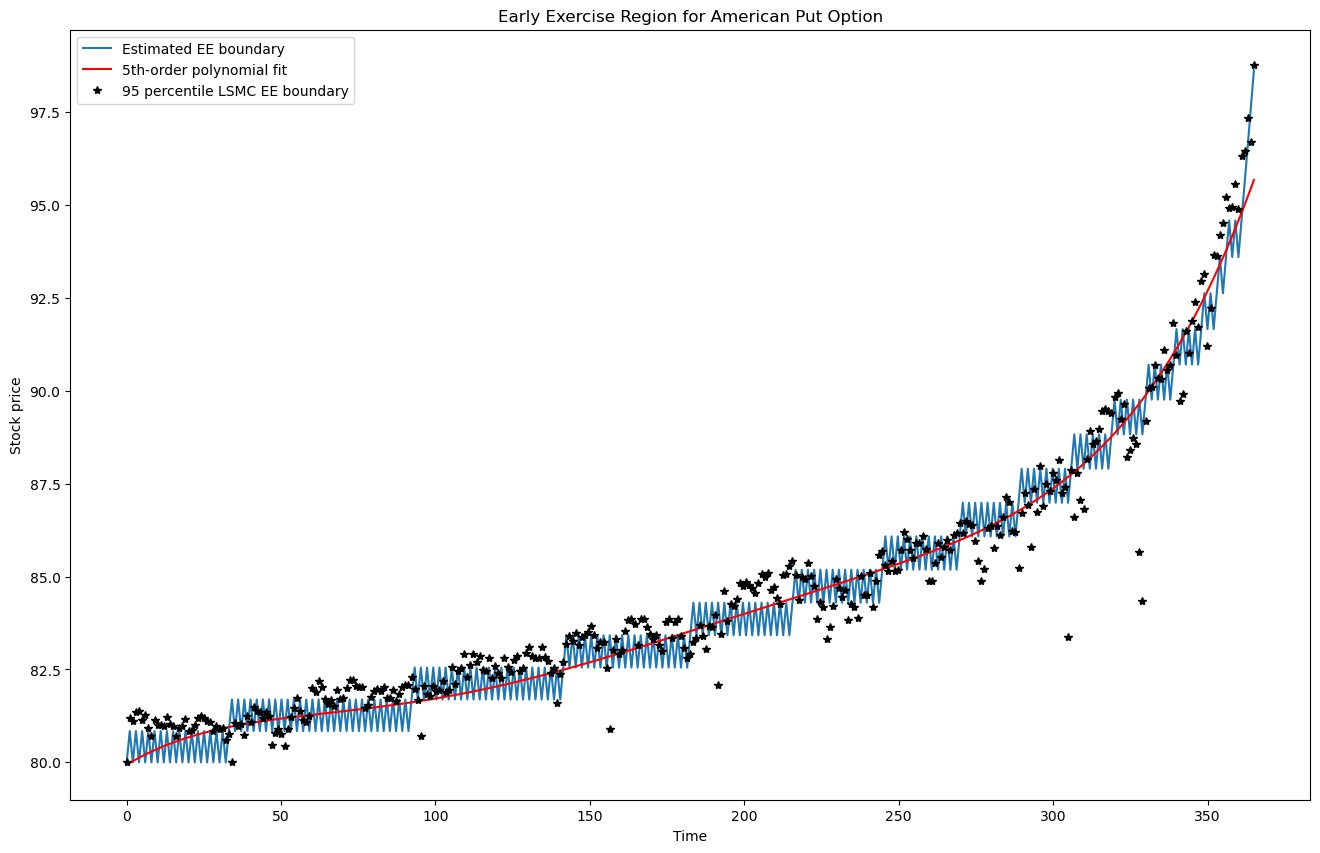

In [9]:
plot_ee_boundaries_95(EE_crr, EE_LSMC, n)

### Conclusion and Comments

In the plot of the estimated EE boundary and the 5th-order polynomial fitted to it, the region below the curve represents the optimal exercise region, and the region above the curve represents the optimal holding region.

The estimated EE boundary curve represents the threshold stock price at which it becomes optimal to exercise the American put option. If the stock price is below the curve, it is better to exercise the option and receive the payoff immediately, while if the stock price is above the curve, it is better to hold onto the option and wait for a potentially larger payoff at a later time.